- To Write a neural network that can:
  * take 2 inputs:
  * an image from MNIST dataset, and
  * a random number between 0 and 9
- and gives three outputs:
  * the **number** that was represented by the MNIST image, and
  * the **sum** & **difference** of this number (predicted) with the random number that was generated and sent as the input to the network
  

# Import Libraries

In [1]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt

# Download the data

In [2]:
# For training set 
# Making the tensor and normalizing the data
train_set = torchvision.datasets.MNIST(
    root='./data',  # creating directory and giving the path
    train=True,     # True for training set
    download=True,  # True if data is not available in local storage
    transform=transforms.Compose([
        transforms.ToTensor(), # convert image to tensor
        transforms.Normalize((0.1307,), (0.3081,)) # Normalize image with mean and standard deviation
    ])
)

# For testing set
# Making the tensor and normalizing the data
test_set = torchvision.datasets.MNIST(
    root='./data',    #  giving the directory path
    train=False,      # False for testing set
    transform=transforms.Compose([
        transforms.ToTensor(),  # convert image to tensor
        transforms.Normalize((0.1307,), (0.3081,))   # Normalize image with mean and standard deviation
    ])
)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


# DataSet Class

In [3]:
class MNISTNum(Dataset):
  def __init__(self, data):
    self.data = data
    self.rand_nums = torch.randint(0, 10, ((len(data)),1), dtype=torch.float)

  def __getitem__(self, i):
    image, label = self.data[i]
    num = self.rand_nums[i]

    sum = label + num
    diff = abs(label - num)
    
    return image, num, label, sum, diff

  def __len__(self):
    return len(self.data)

# Train Test Loaders

In [4]:
torch.manual_seed(1)
batch_size = 256
use_cuda = torch.cuda.is_available() # GPU enabled
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

train_loader = DataLoader(
    MNISTNum(train_set),
    batch_size=batch_size,
    shuffle=True,
    **kwargs
)

test_loader = DataLoader(
    MNISTNum(test_set),
    batch_size=batch_size,
    shuffle=True,
    **kwargs
)

# Data Vizulization

In [5]:
type(next(iter(train_loader))), len(next(iter(train_loader)))

(list, 5)

In [ ]:
next(iter(train_loader))

In [11]:
next(iter(train_loader))[0].shape, next(iter(train_loader))[1].shape, next(iter(train_loader))[2].shape, next(iter(train_loader))[3].shape

(torch.Size([256, 1, 28, 28]),
 torch.Size([256, 1]),
 torch.Size([256]),
 torch.Size([256, 1]))

In [12]:
next(iter(train_loader))[2][10]

tensor(6)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


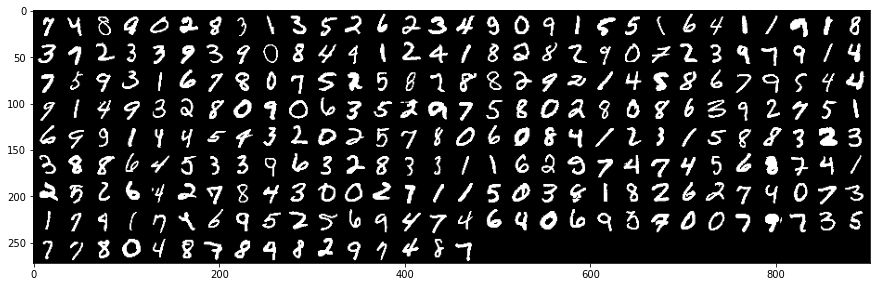

In [13]:
images, num, label, sum, diff = next(iter(train_loader))

grid = torchvision.utils.make_grid(images, nrow=30)    # Creating grid of images
plt.figure(figsize=(15,15))
plt.imshow(np.transpose(grid, (1,2,0)))

In [14]:
images[0].shape

torch.Size([1, 28, 28])

In [18]:
sum[0].item()

10.0

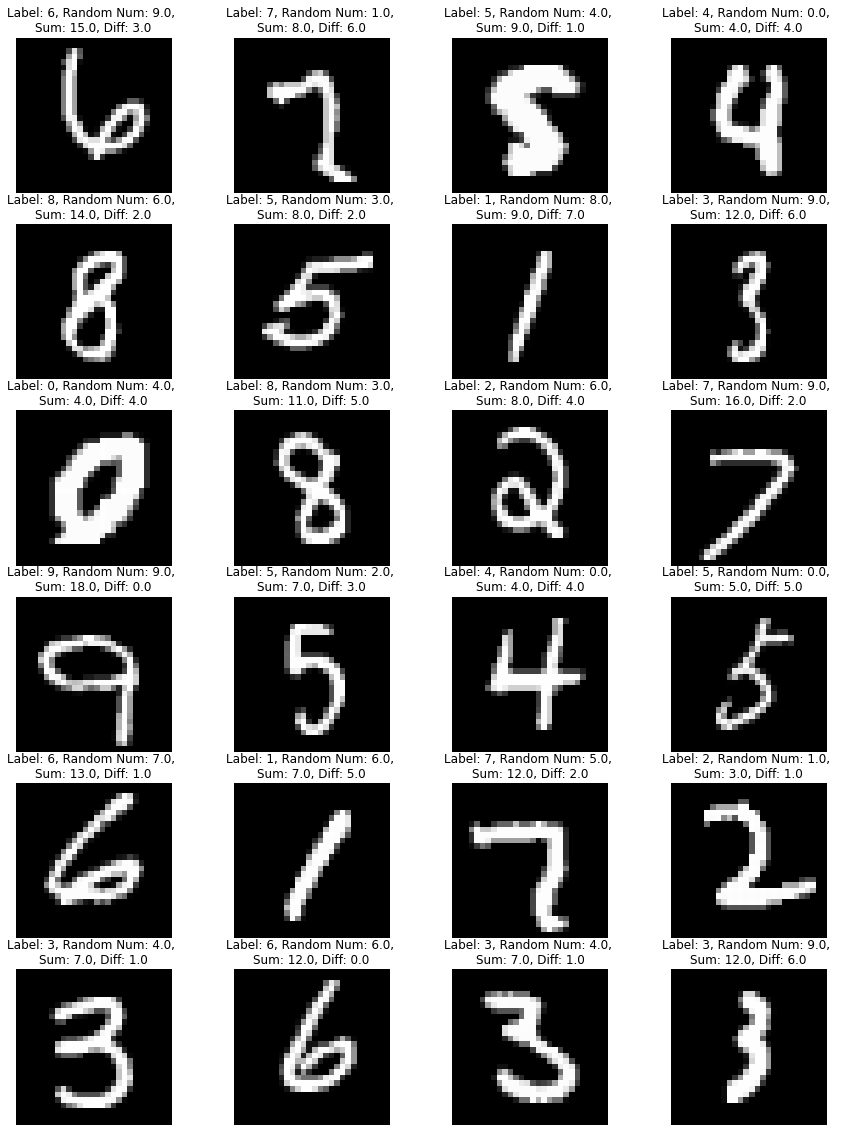

In [19]:
cols, rows = 4,6
figure = plt.figure(figsize=(15, 20))
for i in range(1, cols * rows + 1):
    k = np.random.randint(0, batch_size)

    figure.add_subplot(rows, cols, i)
    plt.title(f"Label: {label[k]}, Random Num: {num[k].item()}, \nSum: {sum[k].item()}, Diff: {diff[k].item()}")
    plt.imshow(images[k].squeeze(), cmap='gray')
    plt.axis('off')

plt.show()

# Define Network

In [20]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1) #input 28*28*1, kernel size -3*3*1, no of kernels 32,  OUtput 28*28*32 LRF =3 GRF =5
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)#input 28*28*32, kernel size -3*3*32, no of kernels 64,  OUtput 28*28*64 LRF =3 GRF =7
        self.pool1 = nn.MaxPool2d(2, 2)#input 28*28*64, kernel size -2*2, no of kernels 64, OUtput 14*14*64 LRF =2 GRF =14
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)#input 14*14*64, kernel size -3*3*64, no of kernels 128,  OUtput 14*14*128,lRF =3 GRF = 16
        self.conv4 = nn.Conv2d(128, 256, 3, padding=1)#input 14*14*128, kernel size -3*3*128, no of kernels 256,  OUtput 14*14*256, LRF =3 GRF =18
        self.pool2 = nn.MaxPool2d(2, 2)#input 14*14*256, kernel size -2*2, no of kernels 256, OUtput 7*7*256 LRF =3 GRF =36
        self.conv5 = nn.Conv2d(256, 512, 3)#input 7*7*256, kernel size -3*3*256, no of kernels 512 ,OUtput 5*5*512 LRF =3 GRF =38
        self.conv6 = nn.Conv2d(512, 1024, 3)#input 5*5*512, kernel size -3*3*512, no of kernels 1024 ,OUtput3*3*1024 LRF =3 GRF =40
        self.conv7 = nn.Conv2d(1024, 10, 3)#input 3*3*1024, kernel size -3*3*1024, no of kernels 10 ,OUtput1*1*10 LRF =3 GRF =42

        self.dense1 = nn.Linear(1, 8)
        self.dense2 = nn.Linear(8, 32)
        # sum
        self.sum1 = nn.Linear(10+32, 64)
        self.sum2 = nn.Linear(64, 128)
        self.sum3 = nn.Linear(128, 1)

        # diff
        self.dif1 = nn.Linear(10+32, 64)
        self.dif2 = nn.Linear(64, 128)
        self.dif3 = nn.Linear(128, 1)

    def forward(self, x, num):# calling defined objects through forward function.
        x = self.pool1(F.relu(self.conv2(F.relu(self.conv1(x))))) # 1 convolutional block
        x = self.pool2(F.relu(self.conv4(F.relu(self.conv3(x)))))
        x = F.relu(self.conv6(F.relu(self.conv5(x))))
        x = self.conv7(x)
        x = x.view(-1, 10)# Flattening of the 1*1*10 matrix 
        out_lab = F.log_softmax(x, dim=1)

        num = F.relu(self.dense2(F.relu(self.dense1(num))))
        num = torch.cat((F.relu(x),num), dim=1)

        # sum processor
        out_sum = F.relu(self.sum1(num))
        out_sum = F.relu(self.sum2(out_sum))
        out_sum = self.sum3(out_sum)

        # diff processor
        out_dif = F.relu(self.dif1(num))
        out_dif = F.relu(self.dif2(out_dif))
        out_dif = self.dif3(out_dif)

        return out_lab, out_sum, out_dif
        

In [21]:
# Loading network
model = Net()
print(model)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv5): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
  (conv6): Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1))
  (conv7): Conv2d(1024, 10, kernel_size=(3, 3), stride=(1, 1))
  (dense1): Linear(in_features=1, out_features=8, bias=True)
  (dense2): Linear(in_features=8, out_features=32, bias=True)
  (sum1): Linear(in_features=42, out_features=64, bias=True)
  (sum2): Linear(in_features=64, out_features=128, bias=True)
  (sum3): Linear(in_features=128, out_features=1, bias=True)
  (dif1): Linear

# Training

In [22]:
device = torch.device("cuda" if use_cuda else "cpu")

In [39]:

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    pbar = tqdm(train_loader)
    for batch_idx, (images, nums, labels, sums, diffs) in enumerate(pbar):
        images, nums, labels, sums, diffs = images.to(device), nums.to(device), labels.to(device), sums.to(device), diffs.to(device)
        
        optimizer.zero_grad()
        pred_lab, pred_sum, pred_diff = model(images, nums)

        loss1 = F.nll_loss(pred_lab, labels)
        loss2 = torch.sqrt(F.mse_loss(pred_sum, sums))
        loss3 = torch.sqrt(F.mse_loss(pred_diff, diffs))
        loss = loss1 + loss2 + loss3

        loss.backward()
        optimizer.step()
        pbar.set_description(desc= f'batch_id={batch_idx} loss={loss.item():.5f} RMSE={loss2.item()+loss3.item():.5f}')
        

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    rmse_loss = 0
    with torch.no_grad():
        for images, nums, labels, sums, diffs in test_loader:
            images, nums, labels, sums, diffs = images.to(device), nums.to(device), labels.to(device), sums.to(device), diffs.to(device)
            pred_lab, pred_sum, pred_diff = model(images, nums)

            loss1 = F.nll_loss(pred_lab, labels, reduction='sum')
            loss2 = torch.sqrt(F.mse_loss(pred_sum, sums, reduction='sum'))
            loss3 = torch.sqrt(F.mse_loss(pred_diff, diffs, reduction='sum'))
            loss = loss1 + loss2 + loss3
          
            test_loss += loss.item()  # sum up batch loss
            rmse_loss += loss2.item() + loss3.item()
            pred = pred_lab.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(labels.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    rmse_loss /= len(test_loader.dataset)
    
    print('Test set: Average loss: {:.4f}, RMSE: {:.4f} Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, rmse_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [33]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
num_epoch = 25

for epoch in range(1, num_epoch+1):
  print('EPOCH: ',epoch)
  train(model, device, train_loader, optimizer, epoch)
  test(model, device, test_loader)

EPOCH:  1


batch_id=234 loss=1.60985 RMSE=1.49058: 100%|██████████| 235/235 [00:35<00:00,  6.57it/s]


Test set: Average loss: 0.1896, RMSE: 0.1071 Accuracy: 9803/10000 (98.03%)

EPOCH:  2


batch_id=234 loss=1.17666 RMSE=1.16993: 100%|██████████| 235/235 [00:35<00:00,  6.62it/s]


Test set: Average loss: 0.1412, RMSE: 0.0903 Accuracy: 9870/10000 (98.70%)

EPOCH:  3


batch_id=234 loss=1.25740 RMSE=1.20855: 100%|██████████| 235/235 [00:35<00:00,  6.65it/s]


Test set: Average loss: 0.1021, RMSE: 0.0579 Accuracy: 9869/10000 (98.69%)

EPOCH:  4


batch_id=234 loss=0.82309 RMSE=0.81141: 100%|██████████| 235/235 [00:35<00:00,  6.64it/s]


Test set: Average loss: 0.0833, RMSE: 0.0504 Accuracy: 9900/10000 (99.00%)

EPOCH:  5


batch_id=234 loss=0.79276 RMSE=0.77185: 100%|██████████| 235/235 [00:35<00:00,  6.62it/s]


Test set: Average loss: 0.0972, RMSE: 0.0634 Accuracy: 9916/10000 (99.16%)

EPOCH:  6


batch_id=234 loss=0.75148 RMSE=0.68540: 100%|██████████| 235/235 [00:35<00:00,  6.60it/s]


Test set: Average loss: 0.1069, RMSE: 0.0756 Accuracy: 9913/10000 (99.13%)

EPOCH:  7


batch_id=234 loss=0.86915 RMSE=0.86557: 100%|██████████| 235/235 [00:35<00:00,  6.62it/s]


Test set: Average loss: 0.0711, RMSE: 0.0437 Accuracy: 9931/10000 (99.31%)

EPOCH:  8


batch_id=234 loss=1.26897 RMSE=1.20019: 100%|██████████| 235/235 [00:35<00:00,  6.61it/s]


Test set: Average loss: 0.0669, RMSE: 0.0384 Accuracy: 9922/10000 (99.22%)

EPOCH:  9


batch_id=234 loss=0.42285 RMSE=0.41806: 100%|██████████| 235/235 [00:35<00:00,  6.62it/s]


Test set: Average loss: 0.0756, RMSE: 0.0472 Accuracy: 9922/10000 (99.22%)

EPOCH:  10


batch_id=234 loss=0.42390 RMSE=0.41656: 100%|██████████| 235/235 [00:35<00:00,  6.62it/s]


Test set: Average loss: 0.0651, RMSE: 0.0399 Accuracy: 9923/10000 (99.23%)

EPOCH:  11


batch_id=234 loss=0.37515 RMSE=0.36480: 100%|██████████| 235/235 [00:35<00:00,  6.61it/s]


Test set: Average loss: 0.0716, RMSE: 0.0445 Accuracy: 9926/10000 (99.26%)

EPOCH:  12


batch_id=234 loss=0.84154 RMSE=0.83830: 100%|██████████| 235/235 [00:35<00:00,  6.61it/s]


Test set: Average loss: 0.0775, RMSE: 0.0454 Accuracy: 9903/10000 (99.03%)

EPOCH:  13


batch_id=234 loss=0.52046 RMSE=0.51783: 100%|██████████| 235/235 [00:35<00:00,  6.61it/s]


Test set: Average loss: 0.0637, RMSE: 0.0409 Accuracy: 9936/10000 (99.36%)

EPOCH:  14


batch_id=234 loss=0.55718 RMSE=0.53333: 100%|██████████| 235/235 [00:35<00:00,  6.59it/s]


Test set: Average loss: 0.0613, RMSE: 0.0351 Accuracy: 9934/10000 (99.34%)

EPOCH:  15


batch_id=234 loss=0.64311 RMSE=0.63365: 100%|██████████| 235/235 [00:35<00:00,  6.62it/s]


Test set: Average loss: 0.0771, RMSE: 0.0497 Accuracy: 9925/10000 (99.25%)

EPOCH:  16


batch_id=234 loss=0.50477 RMSE=0.50218: 100%|██████████| 235/235 [00:35<00:00,  6.61it/s]


Test set: Average loss: 0.0616, RMSE: 0.0418 Accuracy: 9940/10000 (99.40%)

EPOCH:  17


batch_id=234 loss=0.33963 RMSE=0.33795: 100%|██████████| 235/235 [00:35<00:00,  6.61it/s]


Test set: Average loss: 0.0678, RMSE: 0.0437 Accuracy: 9930/10000 (99.30%)

EPOCH:  18


batch_id=234 loss=0.19259 RMSE=0.19110: 100%|██████████| 235/235 [00:35<00:00,  6.63it/s]


Test set: Average loss: 0.0529, RMSE: 0.0331 Accuracy: 9951/10000 (99.51%)

EPOCH:  19


batch_id=234 loss=0.15292 RMSE=0.14987: 100%|██████████| 235/235 [00:35<00:00,  6.62it/s]


Test set: Average loss: 0.0454, RMSE: 0.0283 Accuracy: 9955/10000 (99.55%)

EPOCH:  20


batch_id=234 loss=0.36882 RMSE=0.35859: 100%|██████████| 235/235 [00:35<00:00,  6.62it/s]


Test set: Average loss: 0.0685, RMSE: 0.0413 Accuracy: 9918/10000 (99.18%)

EPOCH:  21


batch_id=234 loss=0.39606 RMSE=0.38842: 100%|██████████| 235/235 [00:35<00:00,  6.62it/s]


Test set: Average loss: 0.0598, RMSE: 0.0370 Accuracy: 9929/10000 (99.29%)

EPOCH:  22


batch_id=234 loss=0.43842 RMSE=0.43584: 100%|██████████| 235/235 [00:35<00:00,  6.62it/s]


Test set: Average loss: 0.0642, RMSE: 0.0405 Accuracy: 9932/10000 (99.32%)

EPOCH:  23


batch_id=234 loss=0.25519 RMSE=0.25130: 100%|██████████| 235/235 [00:35<00:00,  6.61it/s]


Test set: Average loss: 0.0943, RMSE: 0.0476 Accuracy: 9876/10000 (98.76%)

EPOCH:  24


batch_id=234 loss=0.52577 RMSE=0.51031: 100%|██████████| 235/235 [00:35<00:00,  6.61it/s]


Test set: Average loss: 0.0758, RMSE: 0.0443 Accuracy: 9919/10000 (99.19%)

EPOCH:  25


batch_id=234 loss=1.06044 RMSE=1.03322: 100%|██████████| 235/235 [00:35<00:00,  6.63it/s]


Test set: Average loss: 0.0743, RMSE: 0.0455 Accuracy: 9927/10000 (99.27%)



In [34]:
type(next(iter(test_loader))), len(next(iter(test_loader)))

(list, 5)

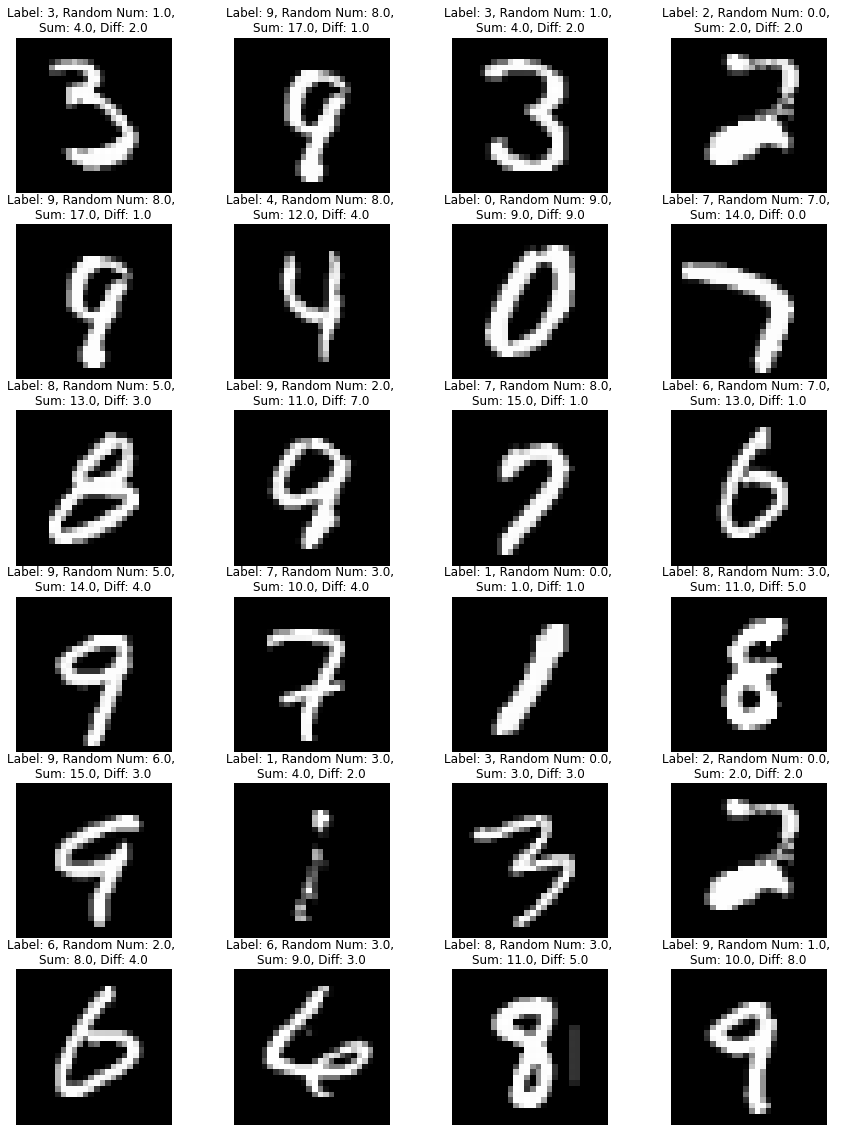

In [35]:
test_img, test_num, test_label, test_sum, test_diff= next(iter(test_loader))

cols, rows = 4,6
figure = plt.figure(figsize=(15, 20))
for i in range(1, cols * rows + 1):
    k = np.random.randint(0, batch_size)

    figure.add_subplot(rows, cols, i)
    plt.title(f"Label: {test_label[k]}, Random Num: {test_num[k].item()}, \nSum: {test_sum[k].item()}, Diff: {test_diff[k].item()}")
    plt.imshow(test_img[k].squeeze(), cmap='gray')
    plt.axis('off')

plt.show()

In [ ]:
torch.save(model.state_dict(), '/content/model.pt')